In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/test/796707dd7.jpg
/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg
/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg
/kaggle/input/global-wheat-detection/test/53f253011.jpg
/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg
/kaggle/input/global-wheat-detection/test/51f1be19e.jpg
/kaggle/input/global-wheat-detection/test/aac893a91.jpg
/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg
/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg
/kaggle/input/global-wheat-detection/test/348a992bb.jpg
/kaggle/input/global-wheat-detection/train/944c60a15.jpg
/kaggle/input/global-wheat-detection/train/dd5dd0234.jpg
/kaggle/input/global-wheat-detection/train/72f8aaa4f.jpg
/kaggle/input/global-wheat-detection/train/69595016d.jpg
/kaggle/input/global-wheat-detection/train/28b8ba0aa.jpg
/kaggle/input/global-wheat-detection/train/2d6357

In [2]:
!pip install torch torchvision


In [3]:
!pip install collection


  Preparing metadata (setup.py) ... done
  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5099 sha256=faa72688eae2567ab3b9a0518343efb6812b06f604df77034ade687bef92595f
  Stored in directory: /root/.cache/pip/wheels/a5/70/eb/1d28795e9384ab3b9be6359bdde9e1652f6e7dab9d26844f70
Successfully built collection


In [4]:
import os
import random
from collections import Counter
import numpy as np
import pandas as pd


from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x: x[1:-1].split(",")).values),columns=['x1','y1','w','h'])

In [7]:
df = pd.concat([train,coord],axis=1)

In [8]:
df.head(5)

,image_id,width,height,bbox,source,x1,y1,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
 5   x1        147793 non-null  object
 6   y1        147793 non-null  object
 7   w         147793 non-null  object
 8   h         147793 non-null  object
dtypes: int64(2), object(7)
memory usage: 10.1+ MB


In [10]:
df["x1"]= df["x1"].astype(float)
df["y1"]= df["y1"].astype(float)
df["w"]= df["w"].astype(float)
df["h"]= df["h"].astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  147793 non-null  object 
 1   width     147793 non-null  int64  
 2   height    147793 non-null  int64  
 3   bbox      147793 non-null  object 
 4   source    147793 non-null  object 
 5   x1        147793 non-null  float64
 6   y1        147793 non-null  float64
 7   w         147793 non-null  float64
 8   h         147793 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 10.1+ MB


In [12]:
df["x2"] = df["x1"] + df["w"]

In [13]:
df["y2"] = df["y1"] + df["h"]

In [14]:
df.head()

,image_id,width,height,bbox,source,x1,y1,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [15]:
df.drop(['bbox','width','height','w','h','source'],axis=1, inplace=True)

In [16]:
df.head(5)

,image_id,x1,y1,x2,y2
0,b6ab77fd7,834.0,222.0,890.0,258.0
1,b6ab77fd7,226.0,548.0,356.0,606.0
2,b6ab77fd7,377.0,504.0,451.0,664.0
3,b6ab77fd7,834.0,95.0,943.0,202.0
4,b6ab77fd7,26.0,144.0,150.0,261.0


In [17]:
df["image_id"].value_counts()

image_id
35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
b70c20580     97
            ... 
a5cb30c38      1
4e6c05213      1
47a1184e4      1
ce4124be0      1
6a62af644      1
Name: count, Length: 3373, dtype: int64

In [18]:
unique_images = df.image_id.unique()

In [19]:
unique_images

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [20]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self,idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:,1:].astype('float')
        img = Image.open("../input/global-wheat-detection/train/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones(boxes.shape[0], dtype = torch.int64)
        
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        
        return T.ToTensor()(img), target
        
        

In [21]:
train_inds, val_inds = train_test_split(range(unique_images.shape[0]), test_size=0.1)

In [22]:
len(val_inds)

338

In [23]:
def custom_collate(data):
    return data

In [24]:
train_dl = torch.utils.data.DataLoader(custDat(df, unique_images, train_inds),
                                      batch_size = 16,
                                      shuffle=True,
                                      collate_fn = custom_collate,
                                      pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df, unique_images,val_inds),
                                      batch_size = 8,
                                      shuffle=True,
                                      collate_fn = custom_collate,
                                      pin_memory = True if torch.cuda.is_available() else False)

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 85.1MB/s] 


In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
device

device(type='cuda')

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
num_epochs = 5

In [29]:
model.to(device)

for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs=[]
        targets =[]
        
        for d in data:
            imgs.append(d[0].to(device))
            
            targ={}
            
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['label'].to(device)
            
            targets.append(targ)
            
        loss_dict=model(imgs, targets)
        
        loss = sum(v for v in loss_dict.values())
        
        epoch_loss += loss.cpu().detach().numpy()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
    print(epoch_loss)
        

213.1778783616445
168.59888908220125
161.39406265586388
156.96994042488845
153.56748208019823


In [30]:
model.eval()
data = iter(val_dl).__next__()

In [31]:
img = data[0][0]
boxes=data[0][1]['boxes']
labels = data[0][1]["label"]

In [32]:
output = model([img.to(device)])

In [33]:
output

[{'boxes': tensor([[ 589.4146,  129.0335,  677.2859,  218.0980],
          [ 924.6904,  810.9630, 1024.0000,  946.5247],
          [ 468.2244,    3.5266,  569.9932,   83.5370],
          [ 533.8574,   45.5383,  642.5053,  132.4702],
          [ 630.3143,  787.7244,  715.1889,  868.9749],
          [ 783.6120,  510.5394,  868.0853,  597.9603],
          [ 814.7537,   81.8784,  907.5563,  174.9816],
          [ 838.7328,  805.7238,  893.4785,  894.7056],
          [ 826.2491,  679.5227,  939.0015,  757.3210],
          [ 220.5135,  786.3893,  299.1390,  867.4733],
          [ 758.0184,  700.0502,  842.2316,  784.4272],
          [ 720.4094,  881.9451,  781.0882,  957.3954],
          [ 101.6364,  756.7007,  163.7449,  823.4807],
          [ 743.7745,  973.0397,  830.0291, 1023.8101],
          [ 745.4583,   64.8825,  840.1077,  143.7679],
          [  80.6100,  829.6735,  187.7061,  935.1432],
          [ 133.3959,  761.2308,  222.7333,  849.8459],
          [ 135.2548,  822.2828,  229.0

In [34]:
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']


In [35]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [36]:
out_bbox.shape,  keep.shape

(torch.Size([46, 4]), torch.Size([39]))

In [38]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[11, 10,  5],
        [10,  9,  4],
        [ 9,  8,  3],
        ...,
        [30, 30, 22],
        [30, 30, 22],
        [29, 29, 21]],

       [[10,  9,  4],
        [10,  9,  4],
        [10,  9,  4],
        ...,
        [30, 30, 22],
        [28, 28, 20],
        [27, 27, 19]],

       [[10,  9,  4],
        [10,  9,  4],
        [10,  9,  4],
        ...,
        [29, 29, 21],
        [26, 26, 18],
        [23, 23, 15]],

       ...,

       [[47, 25, 12],
        [44, 25, 11],
        [47, 25, 12],
        ...,
        [ 8,  5,  0],
        [ 9,  4,  0],
        [10,  5,  1]],

       [[53, 29, 19],
        [51, 29, 18],
        [54, 30, 20],
        ...,
        [ 8,  5,  0],
        [10,  5,  1],
        [11,  6,  2]],

       [[54, 30, 20],
        [53, 29, 19],
        [55, 31, 21],
        ...,
        [ 8,  5,  0],
        [11,  6,  2],
        [12,  7,  3]]], dtype=uint8)

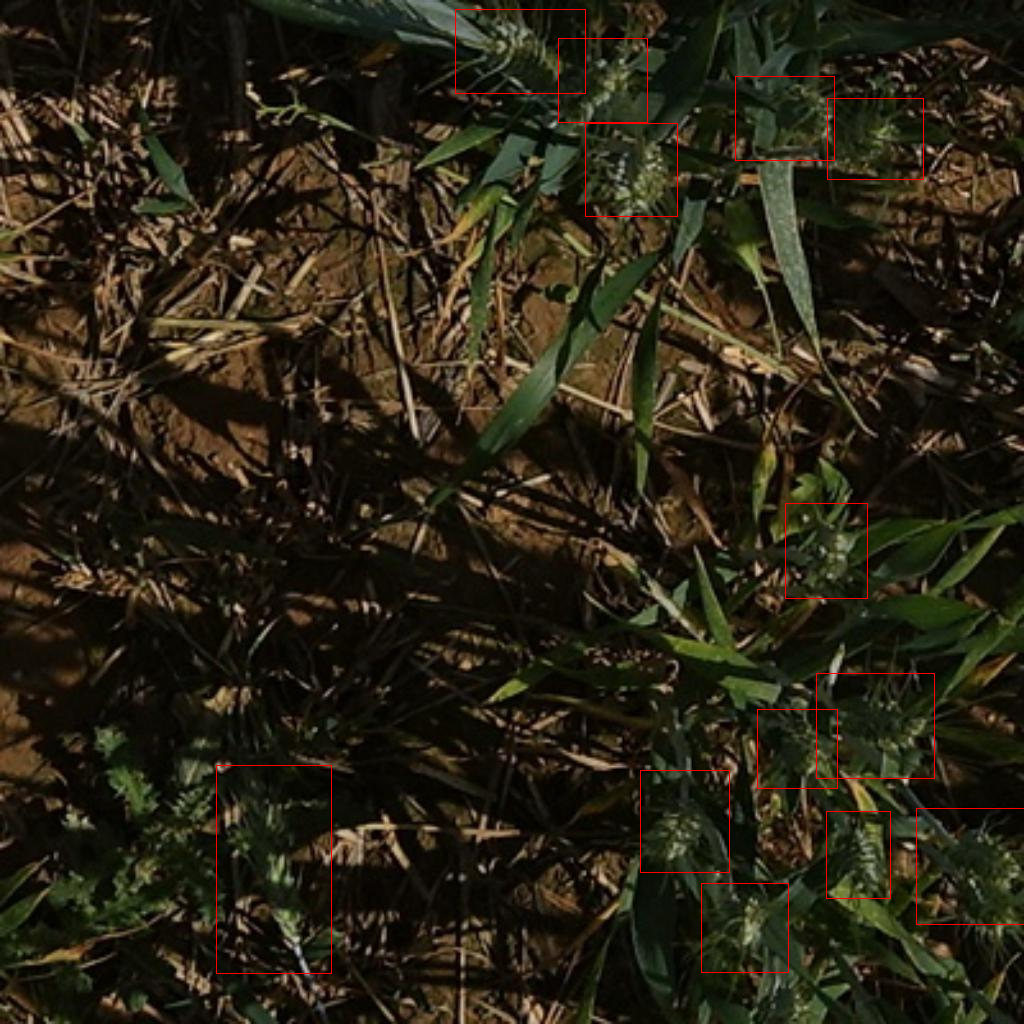

In [40]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)

for box in boxes:
    draw.rectangle(list(box), fill=None, outline='red')
vsample

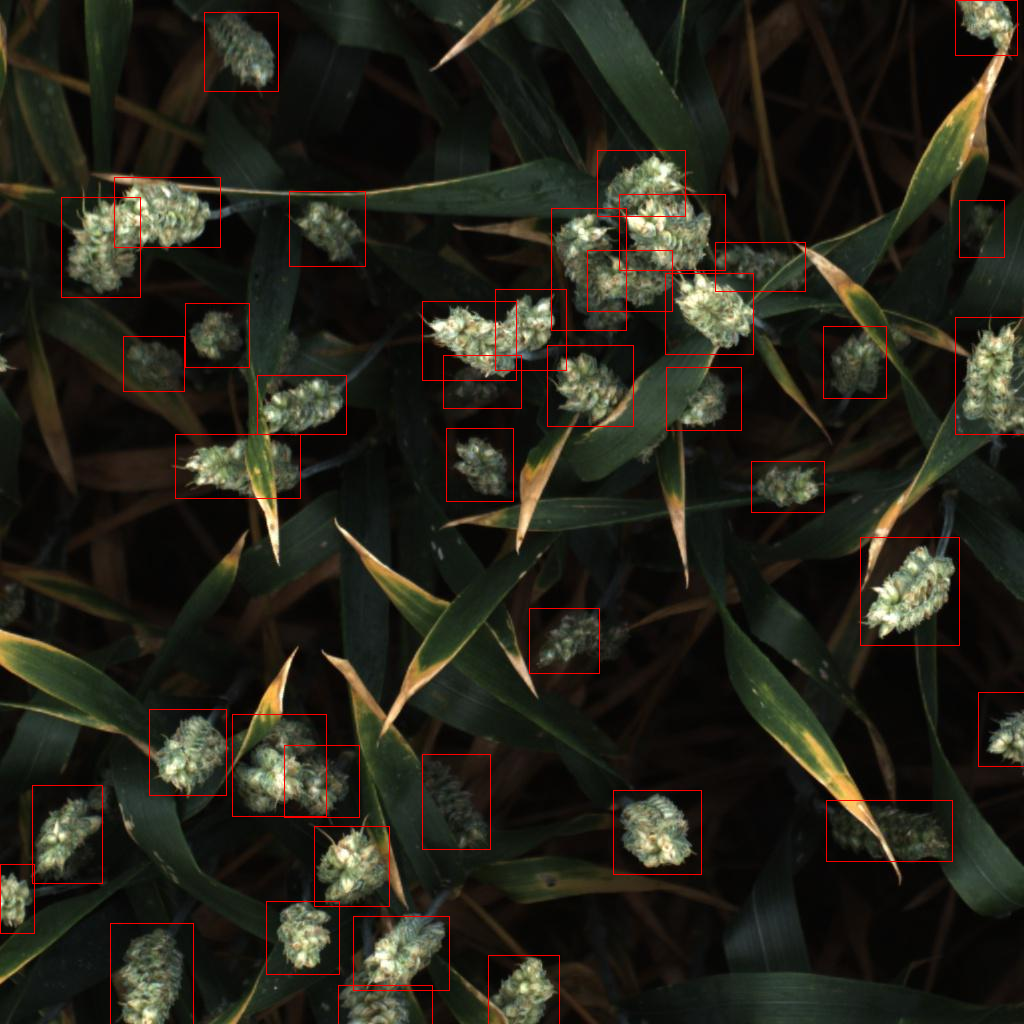

In [44]:
model.eval()
data = iter(val_dl).__next__()

img = data[0][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['label']

output = model([img.to(device)])

out_bbox = output[0]['boxes']
out_scores = output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)

for box in boxes:
    draw.rectangle(list(box), fill=None, outline='red')
vsample